Check class balancing
Fare and Embarked missing values impute based on other variables

Commited to Git


In [43]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import SelectFromModel

In [44]:
train=pd.read_csv('train.csv')
val=pd.read_csv('test.csv')

In [45]:
#Combining training and validation data for feature engineering
train['dataset']= "Train"
val['dataset']="Test"


data= pd.concat([train,val],axis=0)

In [46]:
print(data.shape)
print(data.columns)

print(data.isna().agg('sum'))
#Variable "Age" contains missing values 

(200000, 13)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'dataset'],
      dtype='object')
PassengerId         0
Survived       100000
Pclass              0
Name                0
Sex                 0
Age              6779
SibSp               0
Parch               0
Ticket           9804
Fare              267
Cabin          138697
Embarked          527
dataset             0
dtype: int64


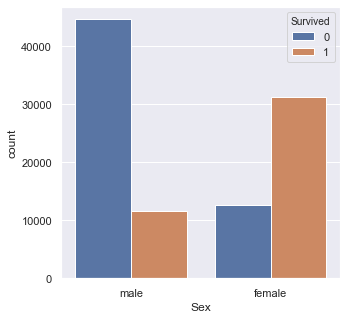

In [47]:
sns.countplot(x='Sex',hue='Survived',data=train)

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, 'Frequency')

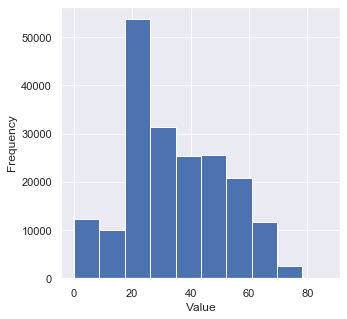

In [48]:
data.head(20)

data.Cabin.value_counts()

plt.hist(x=data.Age, bins=10)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')

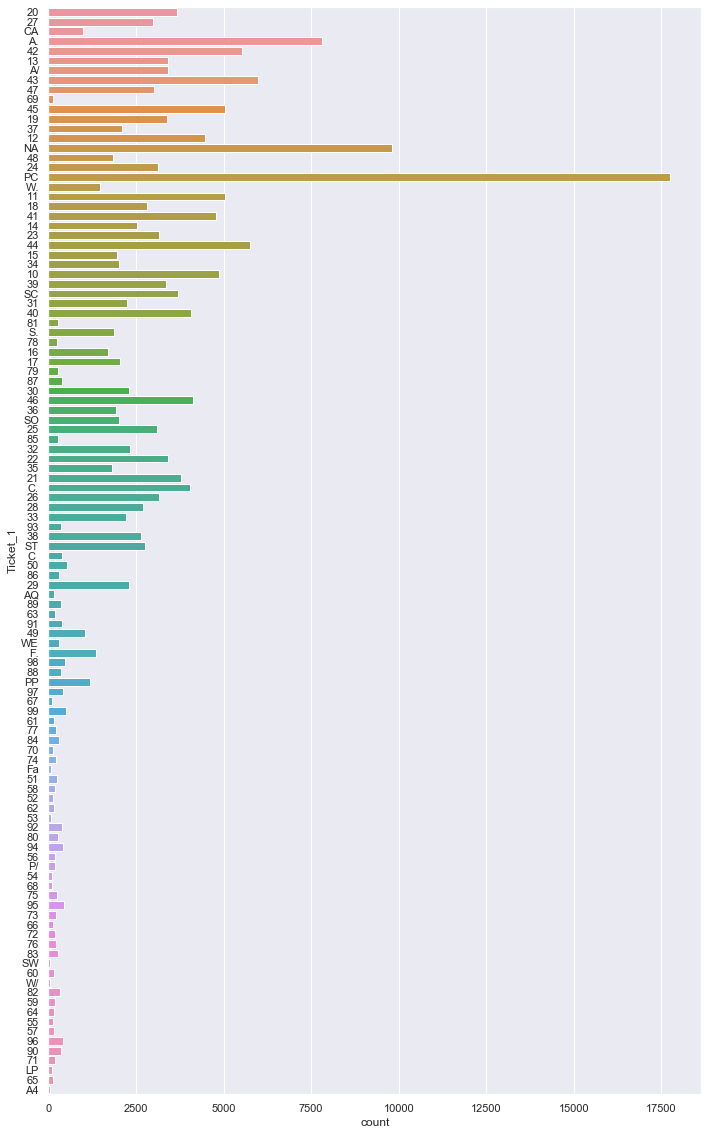

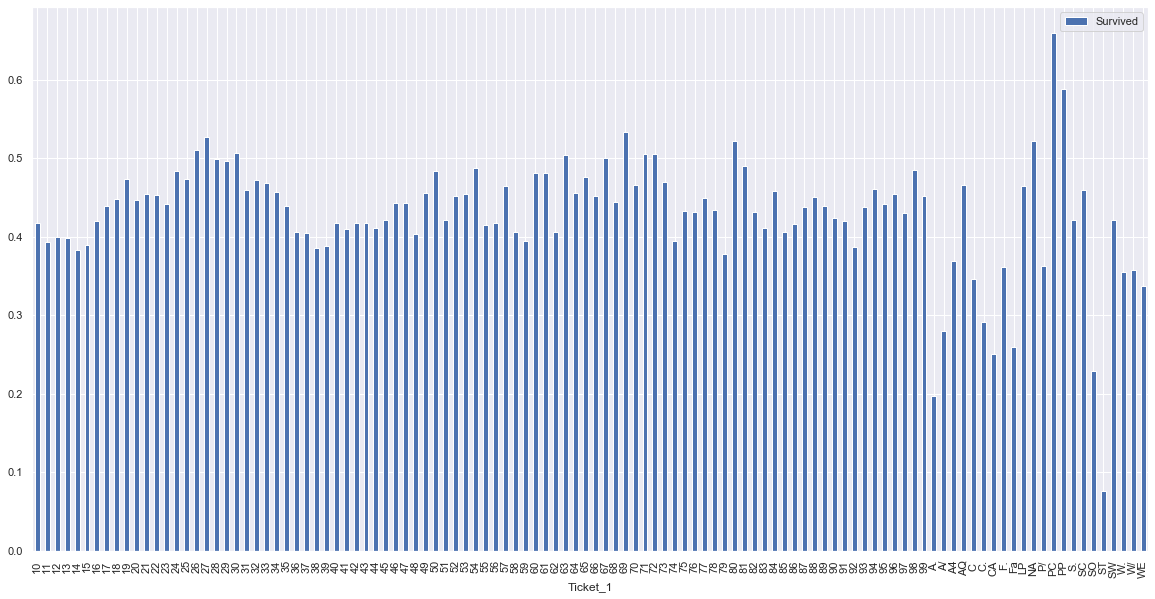

In [49]:
data['Ticket']=data['Ticket'].fillna('NA')

data['Ticket_1']=data['Ticket'].str.slice(stop=2)

sns.set(rc={'figure.figsize':(11.7,20)})

sns.countplot(y='Ticket_1',data=data)

sns.set(rc={'figure.figsize':(5,5)})


p=data[['Ticket_1','Survived']].groupby(['Ticket_1']).agg(np.mean)

p=p.reset_index()

p.plot.bar(x='Ticket_1',y='Survived',figsize=(20,10))



**It can be seen in the charts above Tickets with PP and PC have higher chance of survival**

In [50]:
conditions = [
    (data['Ticket_1'] == 'PC') | (data['Ticket_1'] == 'PP')]
choices = [1]

data['ticket_pp']=np.select(conditions, choices,default=0)

data.ticket_pp.value_counts()

0    181055
1     18945
Name: ticket_pp, dtype: int64

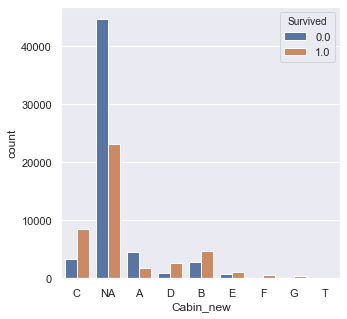

In [51]:
data['Cabin_new']=data.Cabin.str.slice(stop=1)
data['Cabin_new']=data['Cabin_new'].fillna('NA')

sns.countplot(x='Cabin_new',hue='Survived',data=data)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbc2781d690>,
      dtype=object)

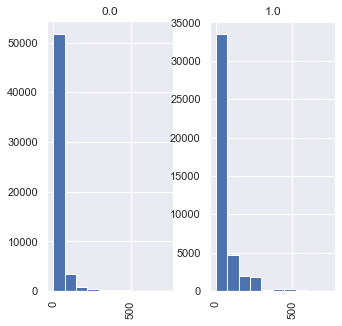

In [52]:
data.Fare.hist(by=[data.Survived])

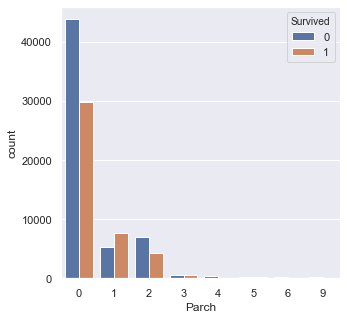

In [53]:
sns.countplot(x='Parch',hue='Survived',data=train)

#Passengers with 0 ,4,5,6 Parch are less likely to survive than 1,2,3

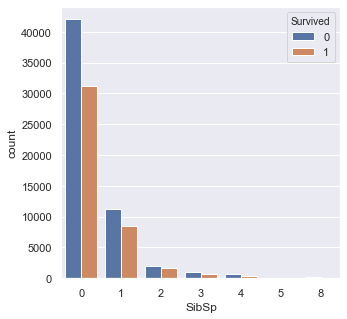

In [54]:
sns.countplot(x='SibSp',hue='Survived',data=train)

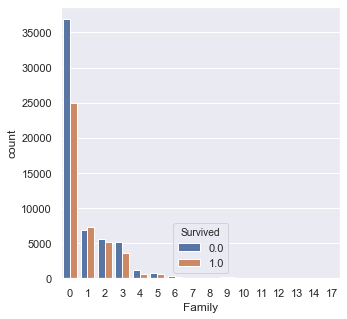

In [55]:
data['Family']=data['SibSp']+data['Parch']

sns.countplot(x='Family',hue='Survived',data=data)

In [56]:
conditions = [
    (data['Family'] == 0),
    (data['Family'] == 1),
    (data['Family'] == 2),
    (data['Family'] == 3),
    (data['Family'] == 4),]
choices = ['0','1','2','3','4']

data['FamSize']=np.select(conditions, choices,default='5')
data.FamSize.value_counts()

0    116448
1     30139
2     25289
3     19724
5      4249
4      4151
Name: FamSize, dtype: int64

**AGE**

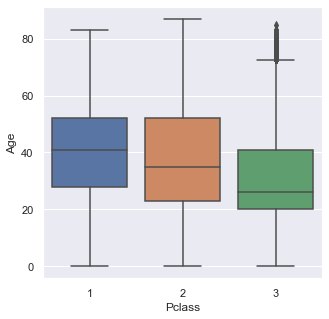

In [57]:
sns.boxplot(x="Pclass",y="Age",data=data)


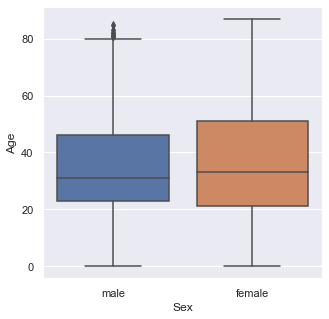

In [58]:
sns.boxplot(x="Sex",y="Age",data=data)


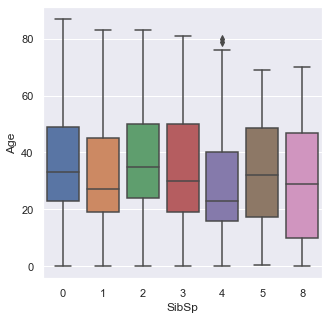

In [59]:
sns.boxplot(x="SibSp",y="Age",data=data)


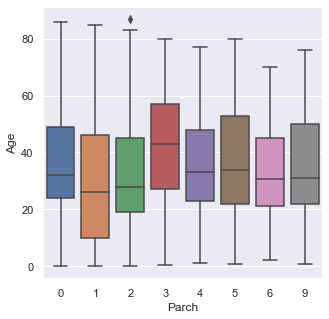

In [60]:
sns.boxplot(x="Parch",y="Age",data=data)

**Average Age varies widely within Sibsp, Pclass, Parch, We can use median ages within these categories to use as proxy data for missing age values**

In [61]:
age_avg=pd.DataFrame(data[['Age','Pclass','Parch','SibSp']].groupby(['Pclass','Parch','SibSp']).median())

age_avg.reset_index(inplace=True)
age_avg['Age_avg']=age_avg['Age']
age_avg=age_avg.drop('Age',axis=1)
m=np.median(age_avg['Age_avg'].dropna())
age_avg=age_avg.fillna(m)

In [62]:
data=data.merge(age_avg,on=['Pclass','Parch','SibSp'],how='left')

In [63]:
data['Age']=data['Age'].fillna(data['Age_avg'])

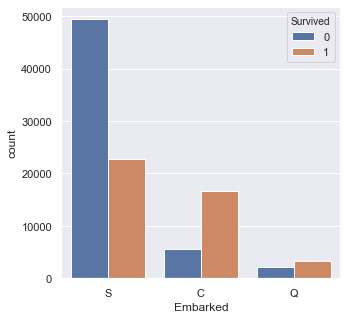

In [64]:
sns.countplot(x='Embarked',hue='Survived',data=train)

In [65]:
print(data['Embarked'].isna().agg('sum'))

data['Embarked']=data['Embarked'].fillna('S')
print(data['Embarked'].isna().agg('sum'))


print(data['Fare'].isna().agg('sum'))
data['Fare']=data['Fare'].fillna(np.mean(data['Fare']))
print(data['Fare'].isna().agg('sum'))

527
0
267
0


**Using one hot encoding for categorical variables**

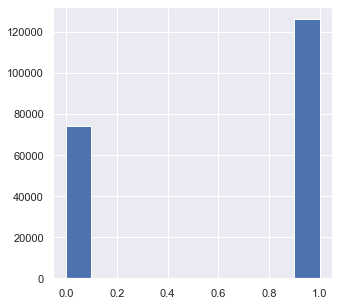

In [66]:
conditions = [
    (data['Sex'] == 'male') ]
choices = [1]

data['Sex']=np.select(conditions, choices,default=0)

data.Sex.hist()

In [67]:
data_final=pd.get_dummies(data,columns=['Pclass','FamSize','Cabin_new','SibSp','Parch','Embarked'],prefix=['Pclass','FamSize','Cabin','SibSp','Parch','Embark'])

data_final=data_final.drop(['PassengerId','Ticket_1','Name','Cabin','Ticket','Age_avg'],axis=1)


data_final.head()

,Survived,Sex,Age,Fare,dataset,ticket_pp,Family,Pclass_1,Pclass_2,Pclass_3,...,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9,Embark_C,Embark_Q,Embark_S
0,1.0,1,39.00,27.14,Train,0,2,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.0,1,28.00,13.35,Train,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0.0,1,0.33,71.29,Train,0,3,0,0,1,...,0,1,0,0,0,0,0,0,0,1
3,0.0,1,19.00,13.04,Train,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,1.0,1,25.00,7.76,Train,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [68]:
Train_final = data_final[data_final['dataset']=='Train']
Val_final=data_final[data_final['dataset']=='Test']

Train_final=Train_final.drop('dataset',axis=1)
Val_final=Val_final.drop(['dataset','Survived'],axis=1)

In [69]:
y=Train_final['Survived']
X=Train_final.drop('Survived', axis =1)

In [70]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=10, test_size=0.2)

In [71]:
from sklearn.ensemble import RandomForestClassifier

params={'max_depth' : [6,8,10], 
       'n_estimators': [50, 100], 
        'min_samples_split': [2, 3], 
        'min_samples_leaf': [1, 3], 
        'bootstrap': [False]
       }

rf=RandomForestClassifier()

rf_b=GridSearchCV(rf,param_grid=params,cv=3) 

rf_b.fit(X_train,y_train)

print(rf_b.best_score_)

print(rf_b.score(X_test,y_test))

print(rf_b.best_params_)

y_rf_pred=rf_b.predict(X_test)

print(confusion_matrix(y_test,y_rf_pred))

y_rf_prob_pred=rf_b.predict_proba(X_test)

print(roc_auc_score(y_test,y_rf_prob_pred[:,1]))

0.7787375511814952
0.7776
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50}
[[9470 1925]
 [2523 6082]]
0.8479960654323294


d={'Feature':np.array(X_train.columns),'Importance':rf_b.best_estimator_.feature_importances_}
Features=pd.DataFrame(d)
Features.sort_values('Importance', inplace=True,ascending=False)

In [72]:
d={'Feature':np.array(X_train.columns),'Importance':rf_b.best_estimator_.feature_importances_} 
Features=pd.DataFrame(d) 
Features.sort_values('Importance', inplace=True,ascending=False)

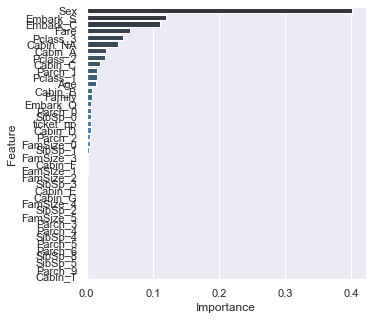

In [73]:
sns.barplot(y='Feature',x='Importance', data=Features,palette="Blues_d")


In [74]:
from sklearn.ensemble import GradientBoostingClassifier

params={'n_estimators':[200,400], 
#        'learning_rate': [ 0.1,0.2,0.4],
#        'max_features': [2,3,4,7],
        'max_depth': [2,4]}

gb=GradientBoostingClassifier(random_state=42)

gb_b=GridSearchCV(gb,param_grid=params,cv=3)
gb_b.fit(X_train,y_train)

print(gb_b.best_score_)

print(gb_b.score(X_test,y_test))

print(gb_b.best_params_)

y_gb_pred=gb_b.predict(X_test)
print(confusion_matrix(y_test,y_gb_pred))

y_gb_prob_pred=gb_b.predict_proba(X_test)

print(roc_auc_score(y_test,y_gb_prob_pred[:,1]))

0.7787500575878292
0.78315
{'max_depth': 2, 'n_estimators': 400}
[[9385 2010]
 [2327 6278]]
0.8499240290870411


In [32]:
d={'Feature':np.array(X_train.columns),'Importance':gb_b.best_estimator_.feature_importances_}
Features_gb=pd.DataFrame(d)
Features_gb.sort_values('Importance', inplace=True,ascending=False)

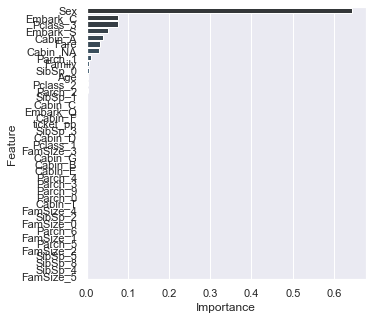

In [75]:
sns.barplot(y='Feature',x='Importance', data=Features_gb,palette="Blues_d")


In [76]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

xgb = XGBClassifier(use_label_encoder=False,verbosity=1)
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#n_scores = cross_val_score(xgb, X_train, y_train, scoring='accuracy', cv=5)
#print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))


parameters = {'eval_metric':['error'],
              'objective':['binary:logistic'],
              'learning_rate': [0.1,0.2], 
              'max_depth': [2,3,4,5],
              'booster' : ['gbtree'],
              'n_estimators': [100],
              'seed': [1337]}


xgb_b = GridSearchCV(xgb, parameters, 
                   cv=3, 
                   scoring='accuracy',
                    refit=True)

xgb_b.fit(X_train,y_train)

print(xgb_b.best_params_)

print(xgb_b.score(X_test,y_test))


{'booster': 'gbtree', 'eval_metric': 'error', 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'objective': 'binary:logistic', 'seed': 1337}
0.78275


In [77]:
ensemble=VotingClassifier(estimators=[ ('XGBoost', xgb_b), ('Random Forest', rf_b), ('Gradient boosting', gb_b)], voting='soft', weights=[1,1,1]).fit(X_train,y_train) 
print('The accuracy for Ensemble is:',ensemble.score(X_test,y_test))

The accuracy for Ensemble is: 0.783


In [78]:
print(Val_final['Fare'].isnull().agg('sum'))

Val_final['Fare']=Val_final['Fare'].fillna(np.mean(Val_final['Fare']))

print(Val_final['Fare'].isnull().agg('sum'))

0
0


In [79]:
pred=xgb_b.predict(Val_final)

pred2=pred.astype('int64')

submission = pd.DataFrame({'PassengerId': val['PassengerId'],'Survived': pred2})

submission.head()

,PassengerId,Survived
0,100000,0
1,100001,1
2,100002,1
3,100003,0
4,100004,1


In [80]:
submission.to_csv("./Submission.csv", index=False)